# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=908c0ed03a42670e6e260a23727bdcbc83a2f152febca1ea890a02a3b02e785a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
rating_df['rating'].unique()

array([3, 1, 2, 4, 5])

In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
      matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [227]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
    
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:33, 1074.18it/s]


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:33, 1070.92it/s]


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 - pairwise_distances(matrix, metric='euclidean')
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1 - pairwise_distances(matrix, metric='manhattan')
    
    
        ###########         end         ###########        
        return similarity_matrix
   
    
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            self.__model = np.matmul(uu_similarity, train_matrix)/normalizer
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = np.transpose(train_matrix)
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            self.__model = np.transpose(np.matmul(ii_similarity, train_matrix)/normalizer)
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[ 1.        , -0.41421356, -0.41421356],
       [-0.41421356,  1.        , -0.41421356],
       [-0.41421356, -0.41421356,  1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[ 1., -1., -1.],
       [-1.,  1., -1.],
       [-1., -1.,  1.]])

The cosine is better than euclidean because in the case that two vectors have same direction but different length, cosine will return 1, which means they are the same, while euclidean will return the difference of their length, which is not very applicable in the situation. 

### (b)

The manhattan penalize the ones that are different with L1-Norm, which could help the situation with L1 normalization.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:32, 1082.95it/s]


In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:34, 1062.50it/s]


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?
user_cosine_recsys = SimBasedRecSys('user','cosine')
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:11, 1710.49it/s]
20000it [00:11, 1705.71it/s]
20000it [00:11, 1705.28it/s]
20000it [00:11, 1718.44it/s]
20000it [00:11, 1708.37it/s]


Processing algorithm user-cosine


20000it [00:11, 1695.31it/s]
20000it [00:11, 1698.75it/s]
20000it [00:11, 1716.74it/s]
20000it [00:11, 1710.74it/s]
20000it [00:11, 1696.59it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.030810777200864,
   1.0251548899002187,
   1.0189149799764732,
   1.0131694372611193,
   1.023022095700391],
  1.0222144360078131,
  1.0139806476089481,
  1.0304482244066782]}

The user based performs better because the average rating per user is higher than average rating per item due to #item > #user. And with more information the prediction can be better and more stable. 

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop, #number of iteration over train data to learn it better
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########

        self.w_Item = sqrt(0.1) * np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = sqrt(0.1) * np.random.randn(num_user, self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],\
                                       self.w_Item[batch_ItemID, :]), axis = 1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :],\
                                       self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :],\
                                       self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

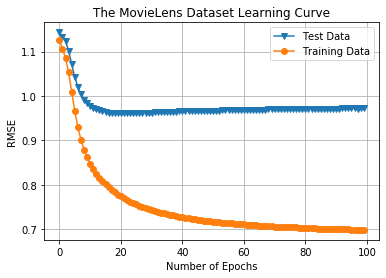

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

In [0]:
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       item_cosine_recsys, 
                       user_cosine_recsys,
                       pmf]

In [0]:
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

In [0]:
result_patk = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
result_ratk = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)
result_rmse = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1763.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:11, 1778.84it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:11, 1787.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1779.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1749.06it/s]


Processing algorithm useraverage


20000it [00:11, 1796.67it/s]
20000it [00:11, 1759.67it/s]
20000it [00:11, 1766.20it/s]
20000it [00:11, 1780.77it/s]
20000it [00:11, 1775.52it/s]


Processing algorithm item-cosine


20000it [00:11, 1769.92it/s]
20000it [00:11, 1797.88it/s]
20000it [00:11, 1777.06it/s]
20000it [00:11, 1775.09it/s]
20000it [00:11, 1748.83it/s]


Processing algorithm user-cosine


20000it [00:11, 1750.16it/s]
20000it [00:11, 1775.18it/s]
20000it [00:11, 1780.43it/s]
20000it [00:11, 1761.85it/s]
20000it [00:11, 1767.35it/s]


Processing algorithm PMF


20000it [00:18, 1104.46it/s]
20000it [00:17, 1120.98it/s]
20000it [00:18, 1101.03it/s]
20000it [00:18, 1095.21it/s]
20000it [00:18, 1099.99it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:11, 1776.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1794.04it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1774.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1763.57it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1766.57it/s]


Processing algorithm useraverage


20000it [00:11, 1793.31it/s]
20000it [00:11, 1788.57it/s]
20000it [00:11, 1792.29it/s]
20000it [00:11, 1797.45it/s]
20000it [00:11, 1810.18it/s]


Processing algorithm item-cosine


20000it [00:11, 1789.32it/s]
20000it [00:11, 1790.58it/s]
20000it [00:11, 1786.66it/s]
20000it [00:11, 1776.87it/s]
20000it [00:11, 1762.08it/s]


Processing algorithm user-cosine


20000it [00:11, 1784.96it/s]
20000it [00:11, 1777.38it/s]
20000it [00:11, 1760.88it/s]
20000it [00:11, 1794.60it/s]
20000it [00:11, 1779.58it/s]


Processing algorithm PMF


20000it [00:17, 1127.95it/s]
20000it [00:17, 1139.30it/s]
20000it [00:17, 1135.27it/s]
20000it [00:17, 1140.91it/s]
20000it [00:17, 1140.82it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1791.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1789.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1804.04it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:11, 1795.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:11, 1788.89it/s]


Processing algorithm useraverage


20000it [00:11, 1806.39it/s]
20000it [00:11, 1810.00it/s]
20000it [00:11, 1801.32it/s]
20000it [00:11, 1803.30it/s]
20000it [00:11, 1768.64it/s]


Processing algorithm item-cosine


20000it [00:11, 1766.89it/s]
20000it [00:11, 1762.07it/s]
20000it [00:11, 1790.93it/s]
20000it [00:11, 1786.38it/s]
20000it [00:11, 1759.62it/s]


Processing algorithm user-cosine


20000it [00:11, 1783.52it/s]
20000it [00:11, 1784.55it/s]
20000it [00:11, 1767.83it/s]
20000it [00:11, 1775.86it/s]
20000it [00:11, 1782.48it/s]


Processing algorithm PMF


20000it [00:17, 1114.69it/s]
20000it [00:18, 1104.68it/s]
20000it [00:17, 1121.56it/s]
20000it [00:17, 1118.97it/s]
20000it [00:18, 1100.99it/s]


In [0]:
print('P@K\n------------------------------')
for key, value in result_patk.items():
  print ('%s \t %f \t %f \t %f'% (key, value[1], value[2], value[3]))
print('\nR@K\n------------------------------')
for key, value in result_ratk.items():
  print ('%s \t %f \t %f \t %f'% (key, value[1], value[2], value[3]))  
print('\nRMSE\n------------------------------')
for key, value in result_rmse.items():
  print ('%s \t %f \t %f \t %f'% (key, value[1], value[2], value[3]))

P@K
------------------------------
popularity 	 0.550583 	 0.405441 	 0.695725
useraverage 	 0.473637 	 0.341999 	 0.605275
item-cosine 	 0.532216 	 0.383701 	 0.680732
user-cosine 	 0.555843 	 0.409598 	 0.702088
PMF 	 0.546172 	 0.403635 	 0.688708

R@K
------------------------------
popularity 	 0.484076 	 0.367137 	 0.601014
useraverage 	 0.441323 	 0.329310 	 0.553336
item-cosine 	 0.474971 	 0.353573 	 0.596369
user-cosine 	 0.486269 	 0.369447 	 0.603090
PMF 	 0.479487 	 0.361781 	 0.597193

RMSE
------------------------------
popularity 	 3.159093 	 3.139293 	 3.178893
useraverage 	 1.043718 	 1.028930 	 1.058505
item-cosine 	 1.020083 	 1.006824 	 1.033342
user-cosine 	 1.022214 	 1.013981 	 1.030448
PMF 	 0.962185 	 0.945627 	 0.978743


### (b)

Popularity can not be evaluated by RMSE as the matrix is calculated by the dividing the liked user by all the user rated, the difference between true value and the number will be very large.

### (c)

For RMSE the best method is PMF. For P@K and R@K is user-cosine but the PMF performance is similar to user-cosine.

PMF is good in most of the cases, because it calculate the prediction based on the U and V matrix with weighted scores to approximate the original matrix. And it has the ability to optimize performance along iterations and hyperparameter tuning. 
User-cosine similarity method is a very quick and common method and with the information from other users, its prediction ability is quite good and in this piticular situation, it is better than PMF.

### (d)

No, good RMSE means prediction is close to the true value and the system can be trusted to rank high similarity items high, but good ranking metrics without normalization sometimes cannot result in good RMSE.

## Q6

### (a)

In [0]:
# get item item similarity matrix
item_matrix = np.transpose(dataPreprocessor(rating_df, num_users, num_items))
ii_similarity = pd.DataFrame(pairwise_distances(item_matrix, metric='cosine'))

# get movie data and select 3 movies
movie_df = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', encoding='latin-1', header=None)
print(movie_df[movie_df.iloc[:, 1].str.contains("Wild Things")].iloc[:, :3])
print(movie_df[movie_df.iloc[:, 1].str.contains("City of Angels")].iloc[:, :3])
print(movie_df[movie_df.iloc[:, 1].str.contains("Palmetto")].iloc[:, :3])

       0                   1            2
913  914  Wild Things (1998)  14-Mar-1998
       0                                 1            2
742  743  Crow: City of Angels, The (1996)  30-Aug-1996
917  918             City of Angels (1998)  03-Apr-1998
         0                1            2
1312  1313  Palmetto (1998)  20-Feb-1998


In [222]:
# 3 movies index
movies = [913, 917, 1312]
for mov in movies:
  top5 = np.argsort(ii_similarity.iloc[:, mov].drop(mov))[:5]
  print("------------------------------------------\n")
  print(movie_df.iloc[mov, 1],"top 5 similar movies \n")
  for m_i in top5:
    print (movie_df.iloc[m_i, 1])

------------------------------------------

Wild Things (1998) top 5 similar movies 

Mercury Rising (1998)
Primary Colors (1998)
Lost in Space (1998)
Wild Things (1998)
Cérémonie, La (1995)
------------------------------------------

City of Angels (1998) top 5 similar movies 

Death in Brunswick (1991)
Mercury Rising (1998)
Young Guns II (1990)
Heaven & Earth (1993)
Wild Things (1998)
------------------------------------------

Palmetto (1998) top 5 similar movies 

Kaspar Hauser (1993)
Pompatus of Love, The (1996)
Winter Guest, The (1997)
Apt Pupil (1998)
Cobb (1994)


### (b)

The result makes some sense to an extend as the item based system will rank those movies rated by same or similar user high, and the user's taste and judgment standard on movie tend to keep same across movies.

## Q7

### (a)

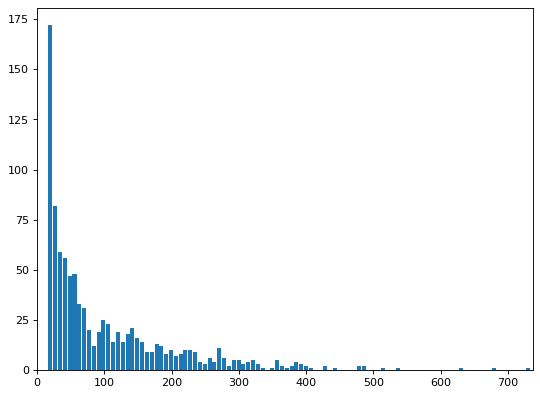

In [0]:
import scipy
from matplotlib.pyplot import figure
# user-iterm matrix
u_i_matrix = dataPreprocessor(rating_df, num_users, num_items)
# get the number of ratings for each user
user = u_i_matrix.astype(bool).sum(axis=1)

# plot
figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
hist, bin_edges = scipy.histogram(user, bins=100)
plt.bar(bin_edges[:-1], hist, width = 6) 
plt.xlim(0, max(bin_edges)) 
plt.show()

In [0]:
u_i_matrix[np.where(user>41)[0]]

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [0]:
def useritermpred(train_matrix, base):
  if base == 'user':
    temp_matrix = np.zeros(train_matrix.shape)
    temp_matrix[train_matrix.nonzero()] = 1
    uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
    # UxI: UxU mul UxI
    normalizer = np.matmul(uu_similarity, temp_matrix)
    #print(normalizer)
    normalizer[normalizer == 0] = 1e-5
    #what's the dimension of np.matmul(uu_similarity, trainSet)
    
    predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
    # if no one has rated this item before, use user average  
    useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
    columns = np.sum(predictionMatrix, axis=0)
    #print(columns.shape)
    predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)  
    return predictionMatrix

    
  elif base == 'item':
    train_matrix = np.transpose(train_matrix)
    temp_matrix = np.zeros(train_matrix.shape)
    temp_matrix[train_matrix.nonzero()] = 1
    ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
    # UxI: UxU mul UxI
    normalizer = np.matmul(ii_similarity, temp_matrix)
    #print(normalizer)
    normalizer[normalizer == 0] = 1e-5
    #what's the dimension of np.matmul(uu_similarity, trainSet)
    
    predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
    # if no one has rated this item before, use user average  
    itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
    columns = np.sum(predictionMatrix, axis=0)
    #print(columns.shape)
    predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)   
    return np.transpose(predictionMatrix)

  else:
    print('No other option available')

In [237]:
datasetsFileNames = [('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]
rmseList = []

def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

for trainFileName, testFileName in datasetsFileNames:
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    
    curTrainUserItemMatrix = dataPreprocessor(curTrainDF, num_users, num_items)
    curTestUserItemMatrix = dataPreprocessor(curTestDF, num_users, num_items)
    
    # overTrainDF = curTrainDF[curTrainDF['userID'].isin(np.where(user>41)[0])]
    # underTrainDF = curTrainDF[curTrainDF['userID'].isin(np.where(user<=41)[0])]
    # overTestDF = curTestDF[curTrainDF['userID'].isin(np.where(user>41)[0])]
    # underTestDF = curTestDF[curTrainDF['userID'].isin(np.where(user<=41)[0])]

    overTrainUserItemMatrix = curTrainUserItemMatrix[np.where(user>41)[0]]
    overTestUserItemMatrix = curTestUserItemMatrix[np.where(user>41)[0]]
    underTrainUserItemMatrix = curTrainUserItemMatrix[np.where(user<=41)[0]]
    underTestUserItemMatrix = curTestUserItemMatrix[np.where(user<=41)[0]]

    #prediction with user based
    overUserSimPreiction = useritermpred(overTrainUserItemMatrix, 'user')
    overUserRMSE = rmse(overUserSimPreiction, overTestUserItemMatrix)
  
    underUserSimPreiction = useritermpred(underTrainUserItemMatrix, 'user')
    underUserRMSE = rmse(underUserSimPreiction, underTestUserItemMatrix)
    
    #prediction with similarity
    overItemSimPreiction = useritermpred(overTrainUserItemMatrix, 'item')
    overItemRMSE = rmse(curItemSimPreiction, overTestUserItemMatrix)
    
    underItemSimPreiction = useritermpred(underTrainUserItemMatrix, 'item')
    underItemRMSE = rmse(underItemSimPreiction, underTestUserItemMatrix)
    
    rmseList.append(('above threshold user based', overUserRMSE, 'above threshold item based', overItemRMSE))
    rmseList.append(('below threshold user based', underUserRMSE, 'below threshold item based', underItemRMSE))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [238]:
for row in rmseList:
  print(row)

('above threshold user based', 1.0176177101131623, 'above threshold item based', 1.215993913182302)
('below threshold user based', 1.1639298102974196, 'below threshold item based', 1.304806704799526)
('above threshold user based', 1.0089233150255363, 'above threshold item based', 1.1964784723304804)
('below threshold user based', 1.1687137360717321, 'below threshold item based', 1.328214626080602)
('above threshold user based', 1.003060365970007, 'above threshold item based', 1.2086126103516175)
('below threshold user based', 1.1594343260006608, 'below threshold item based', 1.34492772628239)
('above threshold user based', 1.0133779056526728, 'above threshold item based', 1.2210697815956788)
('below threshold user based', 1.1705993832588268, 'below threshold item based', 1.2734908167436738)


Yes, there is difference.

The system based on above threshold performs better than the ones based on below. It is because with average rating per user much higher, the information to predict a rating is much higher as well and hence, better prediction.

The item based performs worse than user based as expected and the reason is explained in Q3.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [231]:
validation_df = validateDataPreprocessor()

dataPreprocessor function has error


## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [230]:
validatePopularityRecSys

<function __main__.validatePopularityRecSys>

### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
testEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
testCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
testUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
testIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)